# map2loop: Fetching geospatial data using different protocols


## Shapefile

In [ ]:
import os

#Only for pycharm use, otherwise comment out the next 3 lines!   
print(os.getcwd())
#os.chdir('Dropbox/1_Jupyter_notebooks/map2loop')
print(os.getcwd())


In [ ]:
import geopandas
import os
%matplotlib inline

text=False
graphics=True

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)

shp_geology = geopandas.read_file("../test_data/data/hams2_geol.shp")
if(graphics): 
    shp_geology.plot(column='CODE',figsize=(10,5),edgecolor='#000000',linewidth=0.2 )
if(text):
    print(shp_geology.head())

## GSWA's WFS server

In [ ]:
import geopandas
%matplotlib inline
text=False
graphics=True
bbox='-23,117,-22,118'
wfs_geology=geopandas.read_file("https://services.slip.wa.gov.au/public/services/SLIP_Public_Services/Geology_and_Soils_Map_WFS/MapServer/WFSServer/?service=WFS&version=1.0.0&request=GetFeature&typename=SLIP_Public_Services_Geology_and_Soils_Map_WFS:__2_500_000_State_interpreted_bedrock_geology__DMIRS-014_&BBOX="+bbox+"&srs=EPSG:3857")

if(graphics): 
    wfs_geology.plot(column='code',figsize=(10,10),edgecolor='#000000',linewidth=0.2)
if(text):
    print(wfs_geology.head())

## Loop WFS Server

In [ ]:
import geopandas
%matplotlib inline
text=False
graphics=True
minx=500057
maxx=603028
miny=7455348
maxy=7567953
bbox='500057,7455348,603028,7567953'
print(bbox,text,graphics)

url='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_points_f5011&bbox='+bbox+'&width=768&height=547&srs=EPSG:28350'
print(url)
wfs_geology=geopandas.read_file(url)
if(graphics): 
    wfs_geology.plot(column='feature',figsize=(10,10),linewidth=0.2)
if(text):
    print(wfs_geology.head())

url='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox+'&width=768&height=547&srs=EPSG:28350'
print(url)
wfs_geology=geopandas.read_file(url)
if(graphics): 
    wfs_geology.plot(column='feature',figsize=(10,10),linewidth=0.2)
if(text):
    print(wfs_geology.head())

url='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k_download_join&bbox='+bbox+'&width=768&height=547&srs=EPSG:28350'
print(url)
wfs_geology=geopandas.read_file(url)

if(graphics): 
    wfs_geology.plot(column='code',figsize=(10,10),linewidth=0.2)
if(text):
    print(wfs_geology.head())



## OPeNDAP server (not using pyDAP)

In [ ]:
from urllib.request import urlopen
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
text=False
graphics=True

minlong=117
maxlong=118
minlat=-23
maxlat=-22

minx=(minlong+180)*120
maxx=(maxlong+180)*120
miny=(minlat+90)*120
maxy=(maxlat+90)*120

sizex=maxx-minx+1
sizey=maxy-miny+1
print(sizex,sizey)
minx=str(minx)
maxx=str(maxx)
miny=str(miny)
maxy=str(maxy)
bbox="["+miny+":1:"+maxy+"]["+minx+":1:"+maxx+"]"

link = "http://oos.soest.hawaii.edu/thredds/dodsC/srtm30plus_v11_land.ascii?elev"+bbox

#print (link)
f = urlopen(link)
myfile = f.read()
myfile2=myfile.decode("utf-8") 
data=myfile2.split("---------------------------------------------")
import re

grid=re.sub('\[.*\]','',data[1]).replace(",","").replace("elev.elev","").replace("\n"," ").replace("  "," ")
#print(grid)
grid=grid.split(" ")
grid=grid[2:(sizex*sizey)+2]
OPeNDAP = np.ones((sizey,sizex))
k=0
for j in range (0, sizey, 1):
    for i in range (0, sizex, 1):
        OPeNDAP[sizey-1-j][i]=grid[k]
        k+=1

if(graphics):
    plt.imshow(OPeNDAP)
if(text):
    print(myfile)


In [ ]:
import rasterio
from rasterio.transform import from_origin

print(os.getcwd())

transform = from_origin(minlong, maxlat,0.008333333,0.008333333)

new_dataset = rasterio.open('./test_data/tmp/dtm.tif', 'w', driver='GTiff',
                            height = OPeNDAP.shape[0], width = OPeNDAP.shape[1],
                            count=1, dtype=str(OPeNDAP.dtype),
                            crs='+proj=longlat',
                            transform=transform)

new_dataset.write(OPeNDAP, 1)
new_dataset.close()

## WCS of DTM at a point

In [ ]:
import requests

lat=str(-22.674847)
long=str(124.2773)
coords="pt_lat="+lat+"&pt_long="+long
url="https://elvis2018-ga.fmecloud.com/fmedatastreaming/elvis_tools/ELVIS_GetElevationAtPoint.fmw?"+coords
print(url)
response = requests.get(url)
results=str(response.content, 'utf-8').replace("\"","").split(",")
print("Location Lat :",lat,"Long :",long,results[3])


## SQL query

In [ ]:
import geopandas
import psycopg2  # (if it is postgres/postgis)
%matplotlib inline

con = psycopg2.connect(database="gswa_dh", user="loop", password="loopie123pgpw", host="130.95.198.59")

sql = "select a.* from gswa_500k_ibg as a join public.ham_roi2 as b on ST_INTERSECTS(a.geom, b.geom)"

SQLmap = geopandas.GeoDataFrame.from_postgis(sql, con, geom_col='geom' )
if(graphics):
    SQLmap.plot(column='code',figsize=(10,10))
if(text):
    print(SQLmap.head())

# WCS query

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


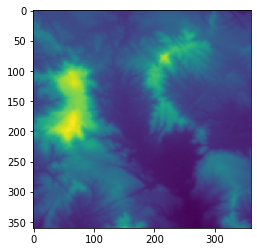

In [5]:
import os
from owslib.wcs import WebCoverageService
from osgeo import gdal
import matplotlib.pyplot as plt
print(os.getcwd())

url="http://services.ga.gov.au/gis/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?"
wcs = WebCoverageService(url,version='1.0.0')

cvg=wcs.getCoverage(identifier='1',  bbox=(117.9,-23,118,-22.9), format='GeoTIFF', crs=4326, width=360, height=360)

f = open('../test_data3/tmp/test_dtm.tif', 'wb')
bytes_written = f.write(cvg.read())
f.close()

ds = gdal.Open('../test_data3/tmp/test_dtm.tif').ReadAsArray()

im = plt.imshow(ds)